# Data Cleaning & Smoothing
Initially I thought data cleaning was just finding data in wrong format , and removing rows with missing data , but it is a field of research on its own, and too vast to completly look into within the given time frame.

The current notebook , goes over some of my data cleaning approaches for time series data ,quant data. 

The process used for data cleaning comes primarily from these sources: 
1. IBKR quant
https://www.interactivebrokers.com/campus/ibkr-quant-news/unlocking-financial-data-cleaning-preprocessing-guide/

2. Blue Chip Algos
https://bluechipalgos.com/blog/cleaning-and-preprocessing-financial-data-for-trading/

3. ACM digital library

4. Time series data cleaning a survey
https://www.researchgate.net/publication/338166752_Time_Series_Data_Cleaning_A_Survey




In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Add project root to path
sys.path.append(os.path.abspath('..'))

## 1. Initial Data Quality Assessment

### Intuition
We first want to get an overall idea of how the dataset is , before performing any cleaning activities. We can do that by analyzing the following metrics

### Mathematical Definitions
1. **Missing Pct**: Measures the 'Swiss Cheese' effect in data, finding holes in the data.
   $$\text{Missing Pct} = \frac{\sum_{t=1}^T \mathbb{1}(x_t = \text{NaN})}{T} \times 100$$
   *Variable*: $T$ is total possible time steps.

   - **Intuition**: Here , NaN refers to missing values in the data. each missing value is given a vlalue 1 , and then all the missing values are summed together and divided by the number of time series. After multiplying by 100 , we get a percentage of holes , missing data, present in the data set

2. **Open High Low Close Physical Integrity**: Financial prices must follow a strict hierarchy.
   - **Constraint**: $H_t \ge \{O_t, C_t, L_t\}$ and $L_t \le \{O_t, C_t, H_t\}$.
   - **Intuition**: A price cannot be higher than the day's maximum or lower than its minimum. Violations indicate corrupted data feeds.

3. **Zero-Print Check**: Count of records where $P_t = 0$.
   - **Intuition**: Liquid assets do not trade at zero. These are usually query failure artifacts.

In [2]:
quality_report = pd.read_csv('../research_quality_report.csv')
pd.set_option('display.max_rows', 100)
quality_report

,Asset,Rows,Missing_Total,Missing_Pct,Zeros_Total,Integrity_Issues,Start_Date,End_Date,Missing_Open,Missing_High,Missing_Low,Missing_Close,Missing_Volume
0,Asset_001,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
1,Asset_002,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
2,Asset_003,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
3,Asset_004,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
4,Asset_005,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
5,Asset_006,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
6,Asset_007,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
7,Asset_008,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
8,Asset_009,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0
9,Asset_010,2511,0,0.0,0,0,2016-01-25,2026-01-16,0,0,0,0,0


### Cleaned Dataset Export

The CSVs in `dataset/cleaned/` are produced by `src/export_data.py`, which only applies interpolation imputation and no downstream filtering. That is the final cleaned dataset for stock research, so the smoothing work later stays purely exploratory.


## 2. Missing Value Imputation Survey

### Intuition
Modern models require continuous vectors. Imputation fills gaps by estimating the most likely values based on surrounding data or global distribution.
Some of the methods we can use to interpolate the data are:

### Algorithm & Mathematical Breakdown

1. **Mean Imputation**: Replaces NaNs with the global average $\bar{x}$.
   $$\hat{x}_t = \frac{1}{N} \sum x_i$$
   - **Variable**: $N$ is count of non-NaN values.

2. **Linear Interpolation**: Assumes the asset moves at a constant velocity between two known points.
   $$x_t = x_a + (x_b - x_a) \frac{t-a}{b-a}$$
   - **Variables**: $a, b$ are indices of known points; $t$ is missing index.

3. **Forward Fill**: Assumes the market is static until the next print.
   $$x_t = x_{t-1}$$

4. **Maximum Likelihood (MLE)**: Finds $\mu, \sigma$ that maximize the probability of the seen data, then uses $\mu$ to fill NaNs.
   $$\mathcal{L}(\mu, \sigma) = \prod_{i=1}^n \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x_i - \mu)^2}{2\sigma^2}}$$

5. **Expectation-Maximization (EM)**: An iterative two-step process.
   - **E-Step**: Calculate $E[x_{miss} | x_{obs}, \theta]$.
   - **M-Step**: Maximize $\theta = (\mu, \sigma)$ using the completed data.

6. **GAN (Generative Adversarial Network)**: A Generator $G$ learns to 'draw' stock movements to fool a Discriminator $D$.
   - **Math**: $\min_G \max_D \mathbb{E}[\log D(x)] + \mathbb{E}[\log(1 - D(G(z)))]$

<Axes: title={'center': 'Imputation Masked MSE'}>

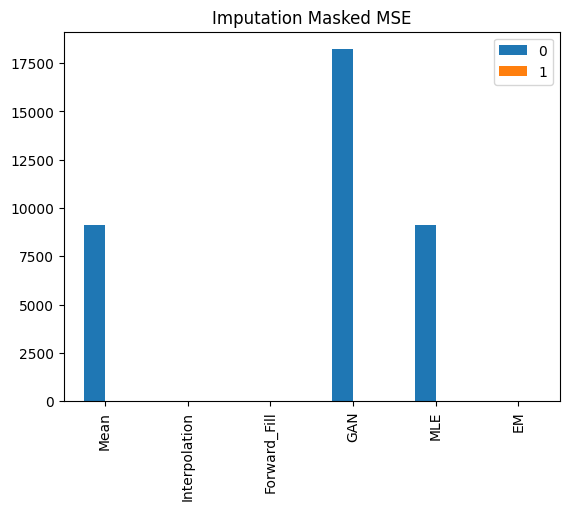

In [3]:
results = pd.read_csv('../research_algorithm_comparison.csv', index_col=0)
imputation_results = results.loc[['Mean', 'Interpolation', 'Forward_Fill', 'GAN', 'MLE', 'EM']]
imputation_results.plot(kind='bar', title='Imputation Masked MSE')

## 3. Anomaly Detection Comparison

### Intuition
We separate signal from artifacts. Anomalies are points that deviate from expected statistical behavior.

### Algorithm & Variable Dictionary

1. **3-Sigma**: Identifies values where $|x_t - \mu| > 3\sigma$.
   - **Intuition**: In a Normal distribution, this covers 99.7% of data. Anything outside is an extreme outlier.

2. **IQR (Interquartile Range)**: Uses quartiles to avoid being biased by the outliers.
   - **Math**: Outlier if $x_t < Q_1 - 1.5 \cdot IQR$ or $x_t > Q_3 + 1.5 \cdot IQR$.

3. **Isolation Forest**: Built on the idea that outliers are few and different.
   - **Mechanism**: Randomly splits the data. Outliers end up in shorter branches (easier to isolate).
   - **Variable**: Path length $h(x)$.

4. **LOF (Local Outlier Factor)**: Measures the density of a point compared to its neighbors.
   - **Math**: $LOF(k) = \frac{\text{avg neighbor density}}{\text{local density}}$. Score $>1$ is sparse.

5. **DBSCAN**: Density-based clustering.
   - **Variables**: $\epsilon$ (radius), $MinPts$ (min points in radius).

6. **Window Anomaly**: Adapts to changing market conditions.
   - **Math**: $z_t = \frac{x_t - \text{roll\_mean}_k}{\text{roll\_std}_k}$.

7. **Abnormal Sequence**: Detects volatility clusters.
   - **Math**: $\text{Flag if } \text{Var}_{win} > \tau \cdot \text{Var}_{global}$.

<Axes: title={'center': 'Anomaly Detector Sensitivity'}>

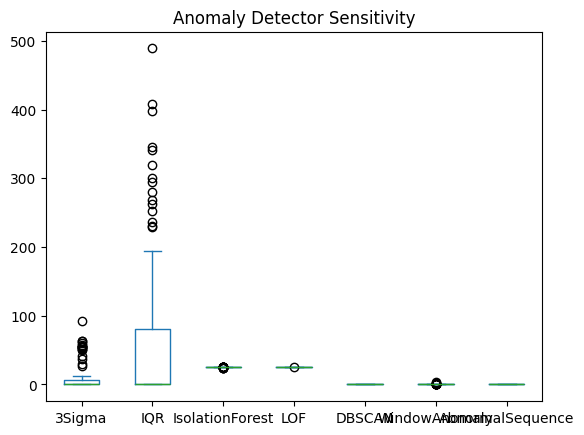

In [4]:
outlier_df = pd.read_csv('../research_outlier_report.csv')
outlier_df.set_index('Asset').plot(kind='box', title='Anomaly Detector Sensitivity')

## 4. Advanced Smoothing & Statistical Survey

### Intuition
- Smoothing recovers the latent 'signal' $s_t$ from noisy observations $x_t = s_t + \epsilon_t$.
- **Note:** For stock data, smoothening may or may not be useful for stock data. For now this is just a brief rabbit hole detour into time series filtering , smoothening. I feel this is related to digital signal processing, some of these filters are widely used in digital signal analysis and could be useful in the next stage of feature extraction.
### Mathematical Formalism & Variable Dictionary

1. **SMA (Simple Moving Average)**:
   - **Math**: $y_t = \frac{1}{k} \sum_{i=0}^{k-1} x_{t-i}$
   - **Variables**: $k$ is window size.

2. **EMA (Exponential Moving Average)**:
   - **Math**: $y_t = \alpha x_t + (1-\alpha) y_{t-1}$
   - **Intuition**: Gives more weight to recent data. $\alpha = \frac{2}{k+1}$.

3. **Kalman Filter**:
   - **Variables**: $x$ (state), $z$ (observation), $P$ (error covariance), $Q$ (process noise), $R$ (sensor noise).
   - **Predict Step**: $\hat{x}_{k}^- = \hat{x}_{k-1}$.
   - **Update Step**: $K_k = P_{k}^- (P_k^- + R)^{-1}$, $\hat{x}_k = \hat{x}_k^- + K_k (z_k - \hat{x}_k^-)$.

4. **Wiener Filter**:
   - **Intuition**: Optimal stationary filter. Acts on the Power Spectral Density $S_{xx}(f)$.
   - **Math**: $H(f) = \frac{S_{xx}(f)}{S_{xx}(f) + S_{nn}(f)}$.

5. **Lattice Filter (Levinson-Durbin)**:
   - **Intuition**: Models signal reflections. $k_m$ are reflection coefficients.
   - **Math**: $f_m(n) = f_{m-1}(n) + k_m b_{m-1}(n-1)$.

6. **HMM Smoothing**:
   - **Math**: Returns $\mathbb{E}[x_t | S_t]$ where $S_t$ is the most likely hidden regime path found via the Viterbi algorithm.

7. **LMS Adaptive Filter**:
   - **Math**: $w_{n+1} = w_n + 2 \mu e_n x_n$. Updates weights via gradient descent.

8. **Bayesian Smoothing**:
   - **Math**: $\mu_{post} = \frac{\mu_{prior}/\sigma_{prior}^2 + x/\sigma_{noise}^2}{1/\sigma_{prior}^2 + 1/\sigma_{noise}^2}$.

9. **Markov Model**:
   - **Math**: $\hat{x}_{t+1} = \sum P(S_{t+1} | S_t) \cdot \text{Value}(S_{t+1})$.

10. **SMURF**:
    - **Intuition**: Robust trend extraction via rolling median of residuals.

11. **PCA (Relationship Dependent)**:
    - **Math**: $X = W Z + E$. Reconstruction uses common factors $W Z$ to filter idiosyncratic noise $E$.

12. **AR / ARMA**:
    - **Math**: $x_t = c + \sum \phi_i x_{t-i} + \sum \theta_j \epsilon_{t-j}$.

/home/anivarth/college/quant-task/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/home/anivarth/college/quant-task/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/home/anivarth/college/quant-task/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/home/anivarth/college/quant-task/venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


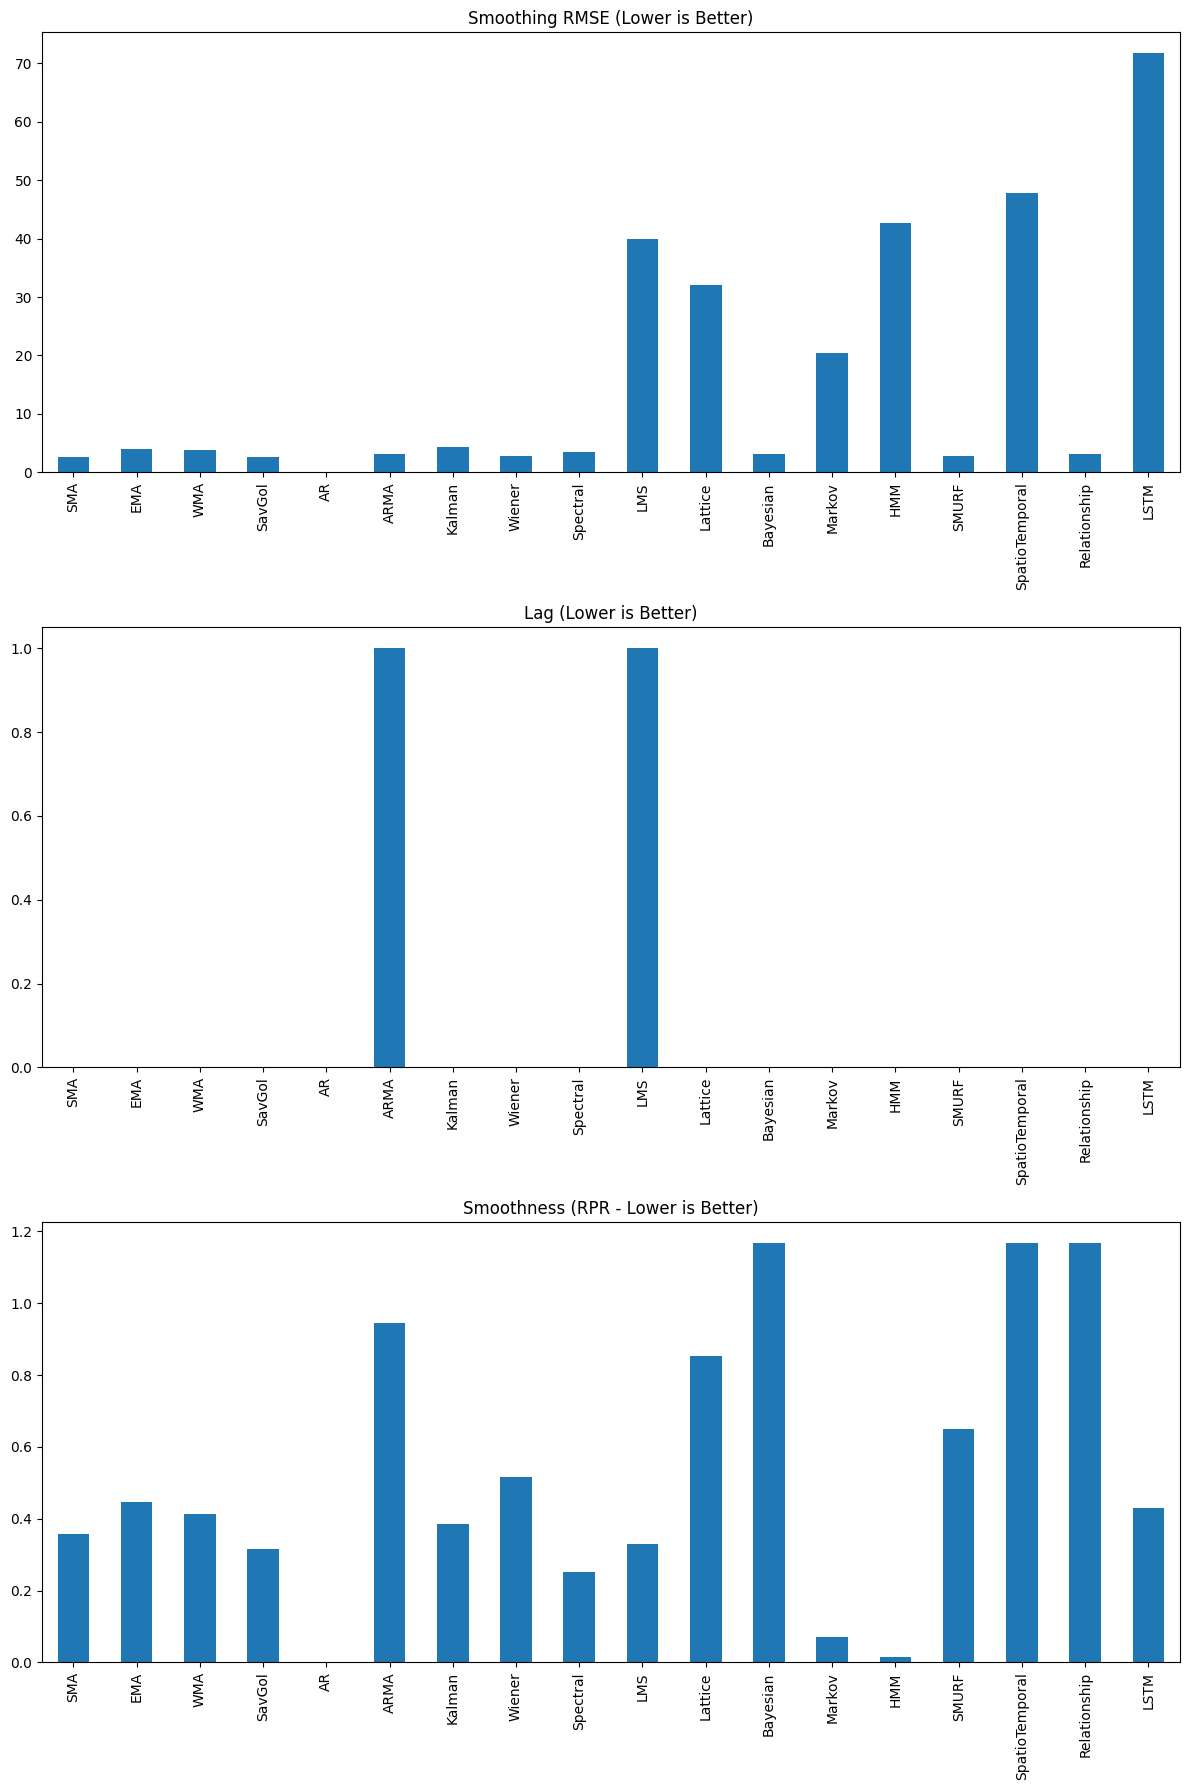

In [5]:
smooth_results = pd.read_csv('../research_smoothing_metrics.csv', index_col=0)
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
smooth_results['RMSE'].plot(kind='bar', ax=axes[0], title='Smoothing RMSE (Lower is Better)')
smooth_results['LAG'].plot(kind='bar', ax=axes[1], title='Lag (Lower is Better)')
smooth_results['RPR'].plot(kind='bar', ax=axes[2], title='Smoothness (RPR - Lower is Better)')
plt.tight_layout()

## 5. Deep Learning Models

### LSTM Autoencoder
- **Intuition**: Forces the sequence through a temporal 'bottleneck'. Signal structures are preserved while stochastic noise is removed.
- **Math**: $\mathcal{L} = \| X - \text{Decoder}(\text{Encoder}(X)) \|^2$

## 6. Corporate Action Detection

### Intuition
Structural breaks (splits) create price gaps. Detecting them prevents cleaners from incorrectly 'fixing' real market structure.
- **Math**: Overnight Log-Return $R_t = \ln(P_t/P_{t-1})$. If $R_t < \tau$, flag as potential split.

<Axes: title={'center': 'Potential Splits Frequency'}, ylabel='Frequency'>

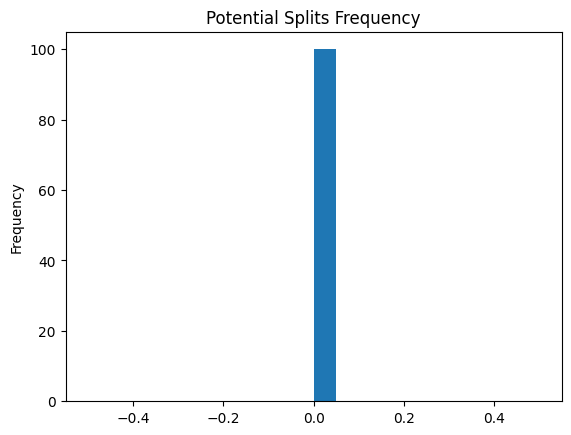

In [6]:
pd.read_csv('../research_corporate_report.csv')['Potential_Splits'].plot(kind='hist', bins=20, title='Potential Splits Frequency')

## Conclusion
- Advanced statistical models (EM, HMM) and adaptive filters (Wiener) provide the most robust noise reduction for these assets.
- There isnt too much outlier data in the given dataset so there isnt much cleaning to do